In [1]:
import einops

from functools import partial
from itertools import product
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    geom_point, 
    geom_histogram, 
    geom_line,
    geom_ribbon,
    qplot, 
    coord_fixed, 
    aes, 
    facet_wrap, 
    labs,
    scale_x_log10,
    scale_y_log10
)
import polars as pl
import torch
from scipy.sparse import coo_array, csr_array
from scipy import linalg
import scipy.sparse.linalg as sparselinalg
from tokengrams import MemmapIndex, InMemoryIndex
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformer_lens import HookedTransformer, HookedTransformerConfig
import zstandard as zstd

In [2]:
torch.cuda.is_available()

True

In [3]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer/tinystories512")
ts_bin_path = 'data/tinystories/train.bin'
index_path = "data/tinystories/ngrams/suffix_tree.idx"

index = MemmapIndex(ts_bin_path, index_path)

In [4]:
epoch = 200
model_path = Path('/media/External01/ngram-checkpoints/4layer_tinystories')

ckpt = torch.load(model_path / f'ckpt{epoch}.pt')

In [5]:

def nanogpt_to_hooked_transformer_config(model_args):
    cfg_dict = {
        "d_model": model_args['n_embed'],
        "n_layers": model_args["n_layer"],
        "d_mlp": model_args["n_embed"] * 4,
        "d_head": model_args["n_embed"] // model_args['n_head'],
        "n_heads": model_args["n_head"],
        "n_ctx": model_args["block_size"],
        "d_vocab": model_args["vocab_size"],
        "tokenizer_name": None,
        "act_fn": 'gelu',
        "attn_only": False,
        "positional_embedding_type": "standard",
        "normalization_type": "LN",
        "original_architecture": 'nanogpt'
    }
    return HookedTransformerConfig(**cfg_dict)


def convert_nanogpt_weights(old_state_dict, cfg: HookedTransformerConfig):
    """For https://github.com/karpathy/nanoGPT
    There are two complications with converting nanogpt models:
    The first is that some state dicts have an unwanted prefix on keys that needs to be removed.
    The second is that the models can be saved with or without bias. By default, there
    is no bias. This function can handle both cases."""
    # Nanogpt models saved after torch.compile() have this unwanted prefix
    # This is a simple way to remove it
    unwanted_prefix = "_orig_mod."
    for k, v in list(old_state_dict.items()):
        if k.startswith(unwanted_prefix):
            old_state_dict[k[len(unwanted_prefix) :]] = old_state_dict.pop(k)

    new_state_dict = {}
    new_state_dict["pos_embed.W_pos"] = old_state_dict["transformer.wpe.weight"]
    new_state_dict["embed.W_E"] = old_state_dict["transformer.wte.weight"]

    new_state_dict["ln_final.w"] = old_state_dict["transformer.ln_f.weight"]
    new_state_dict["ln_final.b"] = torch.zeros_like(old_state_dict["transformer.ln_f.weight"])
    new_state_dict["unembed.W_U"] = old_state_dict["lm_head.weight"].T


    bias = False
    if "transformer.ln_f.bias" in old_state_dict:
        bias = True
        new_state_dict["ln_final.b"] = old_state_dict["transformer.ln_f.bias"]
    else:
         new_state_dict["unembed.b_U"] = torch.zeros(cfg.d_vocab, dtype=cfg.dtype)

    for layer in range(cfg.n_layers):
        layer_key = f"transformer.h.{layer}"

        new_state_dict[f"blocks.{layer}.ln1.w"] = old_state_dict[f"{layer_key}.ln_1.weight"]
        # A bias of zeros is required for folding layer norm
        new_state_dict[f"blocks.{layer}.ln1.b"] = torch.zeros_like(
            old_state_dict[f"{layer_key}.ln_1.weight"]
        )
        new_state_dict[f"blocks.{layer}.ln2.w"] = old_state_dict[f"{layer_key}.ln_2.weight"]
        new_state_dict[f"blocks.{layer}.ln2.b"] = torch.zeros_like(
            old_state_dict[f"{layer_key}.ln_2.weight"]
        )

        new_state_dict[f'blocks.{layer}.attn.mask'] = torch.tril(
            torch.ones((cfg.n_ctx, cfg.n_ctx)).bool()
        )
        new_state_dict[f'blocks.{layer}.attn.IGNORE'] = torch.tensor(-torch.inf)

        W = old_state_dict[f"{layer_key}.attn.c_attn.weight"]
        W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=0)
        W_Q = einops.rearrange(W_Q, "(i h) m->i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "(i h) m->i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "(i h) m->i m h", i=cfg.n_heads)
        new_state_dict[f"blocks.{layer}.attn.W_Q"] = W_Q
        new_state_dict[f"blocks.{layer}.attn.W_K"] = W_K
        new_state_dict[f"blocks.{layer}.attn.W_V"] = W_V

        W_O = old_state_dict[f"{layer_key}.attn.c_proj.weight"]
        W_O = einops.rearrange(W_O, "m (i h)->i h m", i=cfg.n_heads)
        new_state_dict[f"blocks.{layer}.attn.W_O"] = W_O

        new_state_dict[f"blocks.{layer}.mlp.W_in"] = old_state_dict[
            f"{layer_key}.mlp.c_fc.weight"
        ].T
        new_state_dict[f"blocks.{layer}.mlp.W_out"] = old_state_dict[
            f"{layer_key}.mlp.c_proj.weight"
        ].T

        if bias:
            new_state_dict[f"blocks.{layer}.ln1.b"] = old_state_dict[f"{layer_key}.ln_1.bias"]
            new_state_dict[f"blocks.{layer}.ln2.b"] = old_state_dict[f"{layer_key}.ln_2.bias"]
            new_state_dict[f"blocks.{layer}.mlp.b_in"] = old_state_dict[
                f"{layer_key}.mlp.c_fc.bias"
            ]
            new_state_dict[f"blocks.{layer}.mlp.b_out"] = old_state_dict[
                f"{layer_key}.mlp.c_proj.bias"
            ]

            B = old_state_dict[f"{layer_key}.attn.c_attn.bias"]
            B_Q, B_K, B_V = torch.tensor_split(B, 3, dim=0)
            B_Q = einops.rearrange(B_Q, "(i h)->i h", i=cfg.n_heads)
            B_K = einops.rearrange(B_K, "(i h)->i h", i=cfg.n_heads)
            B_V = einops.rearrange(B_V, "(i h)->i h", i=cfg.n_heads)
            new_state_dict[f"blocks.{layer}.attn.b_Q"] = B_Q
            new_state_dict[f"blocks.{layer}.attn.b_K"] = B_K
            new_state_dict[f"blocks.{layer}.attn.b_V"] = B_V
            new_state_dict[f"blocks.{layer}.attn.b_O"] = old_state_dict[
                f"{layer_key}.attn.c_proj.bias"
            ]
        else:
            new_state_dict[f"blocks.{layer}.mlp.b_out"] = torch.zeros(cfg.d_model, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.mlp.b_in"] = torch.zeros(cfg.d_mlp, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_Q"] = torch.zeros(
                (cfg.n_heads, cfg.d_head), dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_K"] = torch.zeros(
                cfg.n_heads, cfg.d_head, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_V"] = torch.zeros(
                cfg.n_heads, cfg.d_head, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_O"] = torch.zeros(cfg.d_model, dtype=cfg.dtype)
            
    return new_state_dict

config = nanogpt_to_hooked_transformer_config(ckpt['model_args'])

In [6]:
from ngram_markov.model import GPT, GPTConfig
from ngram_markov.utils import create_ngrams, nanogpt_to_hooked_transformer_config, convert_nanogpt_weights
from torch.nn.functional import softmax

tl_weights = convert_nanogpt_weights(ckpt['model'], config)
tl_model = HookedTransformer(config)
tl_model.load_state_dict(tl_weights)

#gpt_config = GPTConfig(**ckpt['model_args'])

#gpt_model = GPT(gpt_config)
#gpt_model.load_state_dict(ckpt['model'])
#gpt_model.to('cuda')

<All keys matched successfully>

In [7]:
from ngram_markov.utils import create_ngrams

In [8]:
ngram_seed = [0]
rw_n = 4


In [9]:
random_walks = index.batch_sample(ngram_seed, n=rw_n, k=200, num_samples=200)

In [10]:
import collections
from itertools import islice

def sliding_window(iterable, n):
    "Collect data into overlapping fixed-length chunks or blocks."
    # sliding_window('ABCDEFG', 4) → ABCD BCDE CDEF DEFG
    iterator = iter(iterable)
    window = collections.deque(islice(iterator, n - 1), maxlen=n)
    for x in iterator:
        window.append(x)
        yield tuple(window)


In [11]:

def seq_to_debruijn(rw, n):
    return [ngram for ngram in sliding_window(rw, n-1)]

ngram_walks = [seq_to_debruijn(rw, rw_n) for rw in random_walks]


In [12]:
from ngram_markov.ngrams import create_ngrams, calculate_ngram_kl_divergence


data_dir = Path('data/tinystories')

batch_size = 256
block_size = 300
device_type = 'cuda'
device = 'cuda'

def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(data_dir / 'train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap(data_dir / 'validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x = x.pin_memory().to(device, non_blocking=True)
    else:
        x  = x.to(device)
    return x


In [13]:
import rustworkx as rx
import numpy as np
from typing import List, Tuple
from collections import defaultdict
from itertools import islice

weight_eps = 0.0001

class NgramNode:

    def __init__(self, ngram: Tuple[int]):
        self.ngram = ngram

    def __repr__(self):
        return self.ngram.__repr__()

    @property
    def n(self):
        return len(self.ngram) + 1


def seq_to_debruijn(rw, n):
    return [ngram for ngram in sliding_window(rw, n-1)]


def create_weighted_debruijn_subgraph(ngram_walks: List[List[Tuple[int]]], model) -> rx.PyDiGraph:
    # Step 1: Create a set of unique 3-grams (nodes)
    unique_ngrams = set()
    for walk in ngram_walks:
        unique_ngrams.update(walk)
    unique_ngrams = list(unique_ngrams)
    
    # Step 2: Create a dictionary to map n-grams to node indices
    ngram_to_index = {ngram: i for i, ngram in enumerate(unique_ngrams)}
    
    # Step 3: Create dictionaries for prefix and suffix matching
    prefix_dict = defaultdict(set)
    suffix_dict = defaultdict(set)
    for ngram in unique_ngrams:
        prefix = ngram[:-1]
        suffix = ngram[1:]
        prefix_dict[prefix].add(ngram)
        suffix_dict[suffix].add(ngram)
    
    # Step 4: Calculate n-gram transition probabilities
    ngram_dist = np.array(index.batch_count_next(list(unique_ngrams), 511), dtype=np.float32)
    ngram_dist /= ngram_dist.sum(axis=1)[:, None]
    
    # Step 5: Create all possible edges with weights
    weighted_edges = []
    for ngram in unique_ngrams:
        suffix = ngram[1:]
        source = ngram_to_index[ngram]
        for next_ngram in prefix_dict[suffix]:
            target = ngram_to_index[next_ngram]
            weight = ngram_dist[source, next_ngram[-1]]
            if weight > 0:
                weighted_edges.append((source, target, weight))
            else:
                weighted_edges.append((source, target, weight_eps))
                
    # Step 6: Build the rustworkx graph
    graph = rx.PyDiGraph(multigraph=False)
    graph.add_nodes_from([NgramNode(gram) for gram in unique_ngrams])
    graph.add_edges_from(weighted_edges)
    
    return graph, ngram_to_index



rw_n = 2 # N-gram we are using for the random walk
random_walks = index.batch_sample(ngram_seed, n=rw_n, k=200, num_samples=200)
ngram_walks = [seq_to_debruijn(rw, rw_n) for rw in random_walks] # list of lists, shape: (200, 199)

#tokens = torch.tensor(random_walks, device='cuda') # shape: (200, 201)

#logits, cache = tl_model.run_with_cache(tokens)
#layer1_resids = cache['resid_post', 1] # shape: [200, 201, 512]


graph, ngram_to_index = create_weighted_debruijn_subgraph(ngram_walks, index)

def get_largest_sc_subgraph(graph):
    largest_scc = []
    scc_len = -1
    for cc in rx.strongly_connected_components(graph):
        if len(cc) > scc_len:
            largest_scc = cc
            scc_len = len(cc)
    return graph.subgraph(largest_scc, preserve_attrs=True)

connected_subgraph = get_largest_sc_subgraph(graph)
print(f'Number of nodes: {connected_subgraph.num_nodes()}') # 21_017 nodes


Number of nodes: 8071


In [14]:
def load_checkpoint(n_iters):
    model_path = Path('/media/External01/ngram-checkpoints/4layer_tinystories')
    ckpt = torch.load(model_path / f'ckpt{n_iters}.pt')
    tl_weights = convert_nanogpt_weights(ckpt['model'], config)
    tl_model = HookedTransformer(config)
    tl_model.load_state_dict(tl_weights)
    return tl_model


def project_model_onto_eigenbasis(model, texts, n, layer_idx, index):
    random_walks = texts.tolist()
    full_graph, ngram_to_index = create_weighted_debruijn_subgraph(random_walks, index, n)
    connected_subgraph = get_largest_sc_subgraph(graph)
    mapped_residuals = map_residuals_to_graph(model, layer_idx, random_walks, connected_subgraph, ngram_to_index, n)
    

    

In [32]:
import torch
import numpy as np


def get_activations(model, data, path, layer_idx):
    activations = []
    batch_size = 32
    for batch in data.split(batch_size):
        _, cache = model.run_with_cache(batch.to('cuda'))
        activations.append(cache[path, layer_idx].to('cpu'))
    return torch.concatenate(activations, dim=0)
    

def map_residuals_to_graph(model, layer_idx, sequences, connected_subgraph, n):
    # Initialize a tensor to hold the mapped residuals

    ngram_seqs = [seq_to_debruijn(rw, n) for rw in sequences]
    
    tokens = torch.tensor(sequences) # shape: (200, 201)
    #logits, cache = model.run_with_cache(tokens)
    
    resids = get_activations(model, tokens, 'resid_post', layer_idx)
    #print(resids[0])
    model_dim = resids.shape[-1]
    
    num_nodes = connected_subgraph.num_nodes()
    mapped_residuals = torch.zeros((num_nodes, model_dim), device=resids.device)
    
    # Create a reverse mapping from node index to graph node
    index_to_node = {i: node for i, node in enumerate(connected_subgraph.nodes())}
    
    # Create a mapping from ngrams to their positions in the random walks
    ngram_positions = {}
    for walk_idx, walk in enumerate(ngram_w):
        for pos, ngram in enumerate(walk):
            if ngram not in ngram_positions:
                ngram_positions[ngram] = []
            ngram_positions[ngram].append((walk_idx, pos))
    
    # Map residuals to graph nodes
    for i in range(num_nodes):
        node = index_to_node[i]
        ngram = node.ngram
        
        if ngram in ngram_positions:
            positions = ngram_positions[ngram]
            residuals = resids[
                [pos[0] for pos in positions], 
                [pos[1] for pos in positions], 
                :
            ]
            print(residuals)
            mapped_residuals[i, :] = residuals.mean(dim=0)
    
    return mapped_residuals


tl_model = load_checkpoint(300)

# Usage
random_walk_n = 2
tokens = get_batch('train').cpu().tolist()
token_ngrams = [seq_to_debruijn(seq, random_walk_n) for seq in tokens] # list of lists, shape: (200, 199)
graph, ngram_to_index = create_weighted_debruijn_subgraph(ngram_walks, index)
connected_subgraph = get_largest_sc_subgraph(graph)

mapped_residuals = map_residuals_to_graph(tl_model, 3, tokens, connected_subgraph, random_walk_n)

print("Shape of mapped residuals:", mapped_residuals.shape)
print("First few values of mapped residuals:", mapped_residuals[:5])

# Check if we have mapped residuals for all nodes
print("Nodes with non-zero residuals:", (mapped_residuals != 0).sum().item())
print("Total nodes in the graph:", connected_subgraph.num_nodes())

Shape of mapped residuals: torch.Size([8071, 512])
First few values of mapped residuals: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Nodes with non-zero residuals: 0
Total nodes in the graph: 8071


In [29]:
mapped_residuals

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [16]:
import scipy
from scipy.sparse import csr_array
import cola


@torch.compile
def calc_perron_vector(matrix, n_iter=5):
    vec = torch.ones((matrix.shape[0],), device=matrix.device)
    for _ in range(n_iter):
        new_vec = matrix @ vec
        new_vec /= new_vec.pow(2).sum().sqrt()
        vec = new_vec
    return vec
    

def symmetric_directed_laplacian(adjacency_matrix, device, n_iter=5):
    n = adjacency_matrix.shape[0]
    perron = cola.ops.Diagonal(calc_perron_vector(adjacency_matrix, n_iter=n_iter)).to(device)
    adj = cola.ops.Dense(adjacency_matrix).to(device)
    Ident = cola.ops.I_like(perron).to(device)
    laplacian = (cola.sqrt(perron) @ adj @ cola.inv(cola.sqrt(perron)))
    laplacian +=  (cola.inv(cola.sqrt(perron)) @ adj.T @ cola.sqrt(perron))
    laplacian /= 2       
    return cola.SelfAdjoint(Ident - laplacian).to(device)



def directed_laplacian(adjacency_matrix, device, n_iter=5):
    n = adjacency_matrix.shape[0]
    perron = cola.ops.Diagonal(calc_perron_vector(adjacency_matrix, n_iter=n_iter))
    perron.to(device)
    adj = cola.ops.Dense(adjacency_matrix)
    adj.to(device)
    Ident = cola.ops.I_like(perron)

    laplacian = (cola.sqrt(perron) @ adj @ cola.inv(cola.sqrt(perron)))
                   
    return (Ident - laplacian).to(device)




/home/dashiell/workspace/ngram-markov/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.


In [137]:
ngram_data4 = {n : pl.scan_parquet(f'kl_divs/layers4/{n}gram_kl_layers.parquet') for n in range(1, 17)}


In [139]:
ngram_data4[2]

In [146]:

df = (
    ngram_data4[3]
    .group_by(['layers', 'steps'])
    .agg(
        kl_mean = pl.col('value').mean(),
        kl_med = pl.col('value').median(),
        kl_std = pl.col('value').std(),
        kl10 = pl.col('value').quantile(0.10),
        kl25 = pl.col('value').quantile(0.25),
        kl75 = pl.col('value').quantile(0.75),
        kl90 = pl.col('value').quantile(0.90),
        kl_min = pl.col('value').min(),
        kl_max = pl.col('value').max(),
    )
    .with_columns(layer_named = 'Layer ' + pl.col('layers'))
    .collect()
)

In [147]:
df.filter(pl.col('layers').eq('4') & pl.col('kl_med').lt(1.)) .sort('steps')

layers,steps,kl_mean,kl_med,kl_std,kl10,kl25,kl75,kl90,kl_min,kl_max,layer_named
str,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str
"""4""",300,1.118041,0.891519,0.864469,0.276351,0.485187,1.519787,2.251275,0.007421,9.338759,"""Layer 4"""
"""4""",400,1.007175,0.789577,0.832467,0.226159,0.432839,1.332366,2.058423,0.003284,9.194059,"""Layer 4"""
"""4""",500,0.886571,0.673302,0.786667,0.194289,0.370533,1.147248,1.826264,0.002508,10.575636,"""Layer 4"""
"""4""",600,0.871267,0.652724,0.780273,0.170185,0.345553,1.152772,1.842434,0.00142,9.566333,"""Layer 4"""
"""4""",700,0.897438,0.668674,0.815137,0.144929,0.341746,1.199785,1.942187,0.000475,8.988729,"""Layer 4"""
"""4""",800,0.992436,0.717663,0.942029,0.13491,0.34716,1.329839,2.212055,0.000291,10.134308,"""Layer 4"""
"""4""",900,1.085961,0.761893,1.057885,0.131116,0.356205,1.468318,2.482575,0.00023,10.605287,"""Layer 4"""
"""4""",1000,1.237514,0.864514,1.218311,0.133057,0.394651,1.672123,2.865408,0.000132,11.512757,"""Layer 4"""
"""4""",1100,1.356096,0.954216,1.324774,0.14178,0.429008,1.854542,3.130466,0.000041,14.056032,"""Layer 4"""


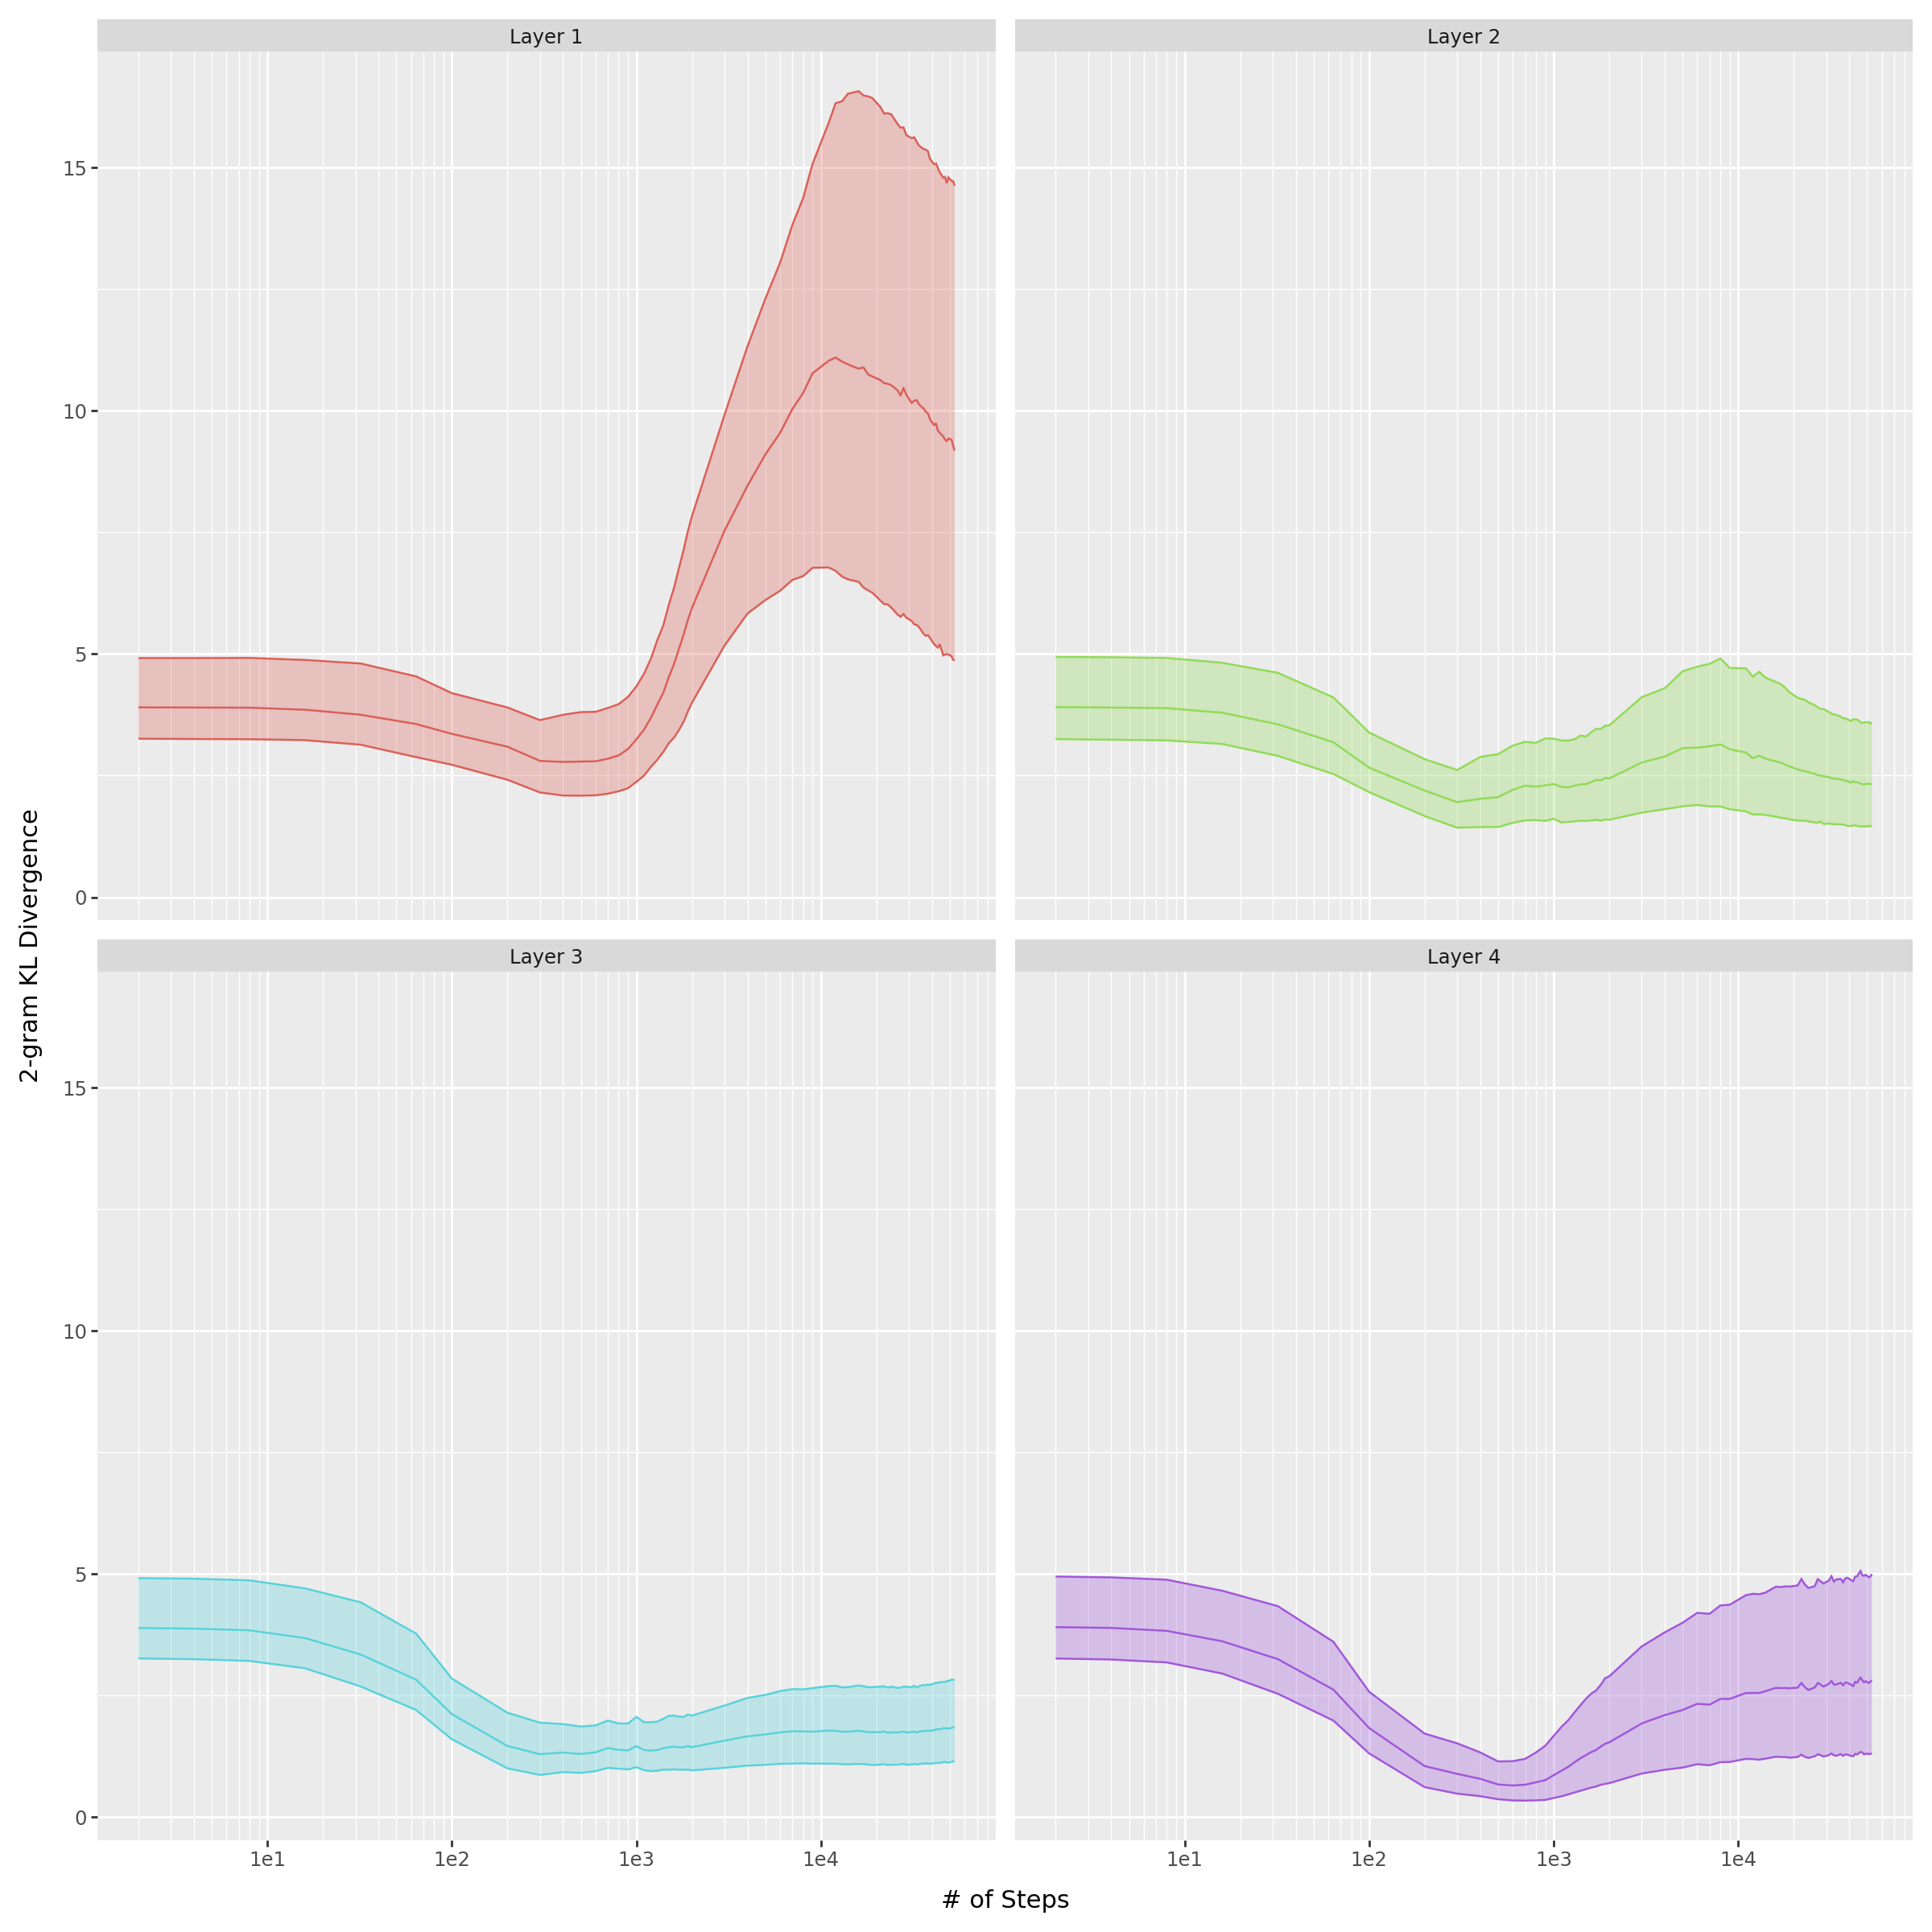

In [148]:
from plotnine import ggplot, geom_histogram, geom_boxplot, facet_wrap, labs, geom_line, geom_ribbon, scale_x_log10, scale_y_log10, theme
#layer_kl = estimate_layer_kl(model, 2, 64)
#bigram_df = pl.DataFrame(layer_kl).melt(variable_name='layer')
(
    ggplot(df.filter(pl.col('layers').ne('0')), aes(x='steps', y='kl_med', ymin='kl25', ymax='kl75', fill='layer_named', color='layer_named')) 
    + geom_line(show_legend=False) 
    + geom_ribbon(alpha=0.3, show_legend=False) 
    + scale_x_log10() 
    + facet_wrap('~layer_named')
    + labs(x = '# of Steps', y = '2-gram KL Divergence')
    + theme(figure_size = (12, 12))
)

In [17]:
adj_mat = torch.from_numpy(
    rx.adjacency_matrix(connected_subgraph, weight_fn= lambda x: float(x))
).to(torch.float32)
adj_mat /= adj_mat.sum(dim=1)[:, None]

In [18]:
laplacian = symmetric_directed_laplacian(adj_mat, torch.device('cuda'))
#dir_laplacian = directed_laplacian(adj_mat, torch.device('cuda'))
#top_eigvals, top_eigvecs = cola.eig(laplacian, k=2000, which='LM')
#bot_eigvals, bot_eigvecs = cola.eig(laplacian, k=1000, which='SM')
#eig_df = pl.DataFrame({'eigvals': top_eigvals.squeeze().cpu().numpy()}).with_columns(source=pl.lit('top'))
#bot_df = pl.DataFrame({'eigvals': bot_eigvals.squeeze().cpu().numpy()}).with_columns(source=pl.lit('bottom'))
#eig_df = pl.concat([top_df, bot_df], how='vertical')


/home/dashiell/workspace/ngram-markov/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
/home/dashiell/workspace/ngram-markov/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
/home/dashiell/workspace/ngram-markov/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.


In [19]:
eigvals, eigvecs = torch.linalg.eigh(laplacian.to_dense())

In [20]:
eigvals

tensor([-1.2986, -1.2795, -1.2760,  ...,  3.2760,  3.2788,  3.2980],
       device='cuda:0')

In [21]:
eig_df = pl.DataFrame({'eigvals': eigvals.cpu().numpy()}).with_columns(source=pl.lit('top'))


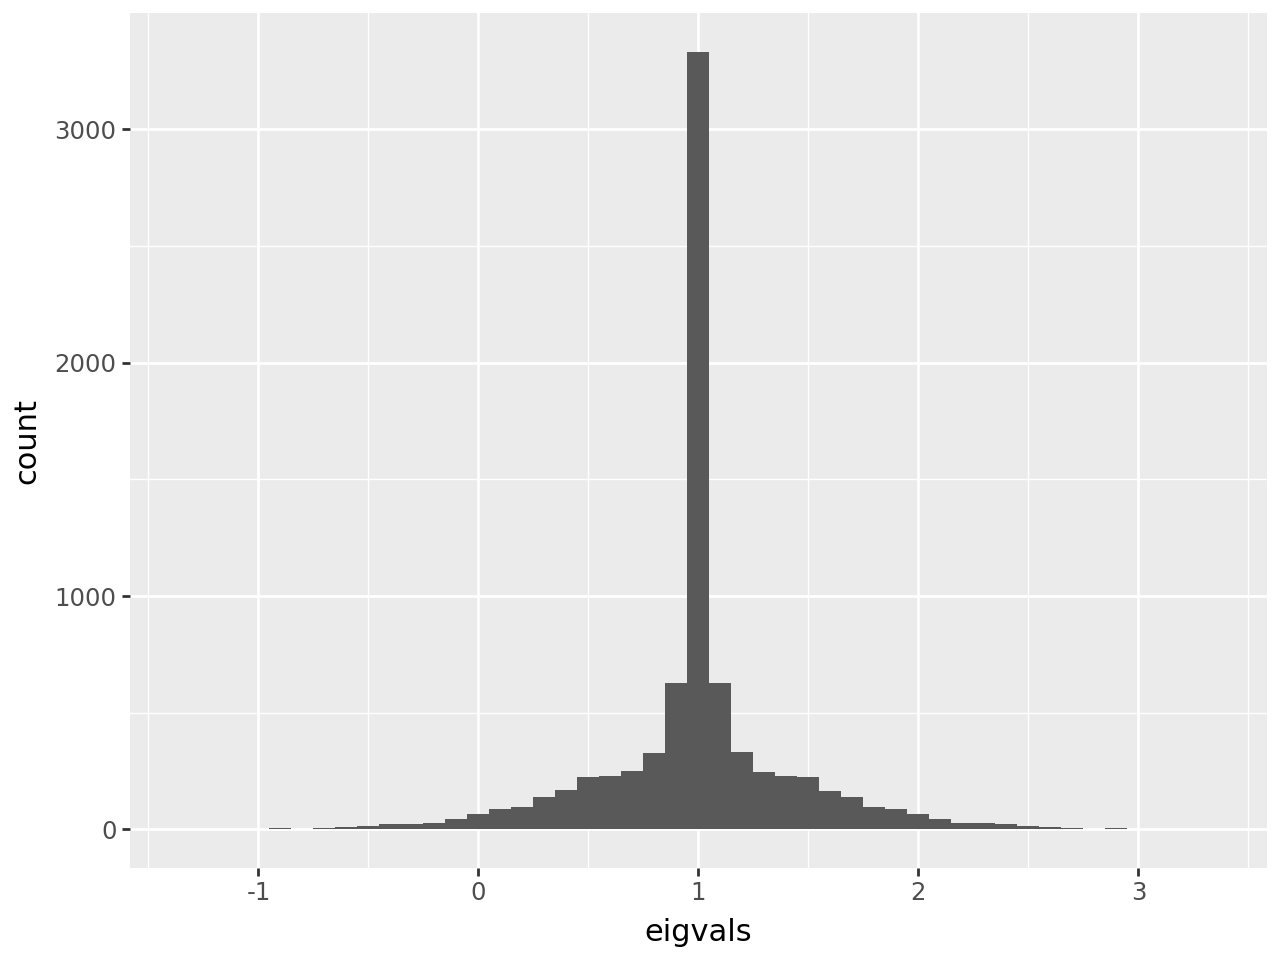

In [22]:
ggplot(eig_df, aes(x='eigvals')) + geom_histogram(binwidth=0.1)

In [23]:
eigenbasis = eigvecs[eigvals.abs() >= 1, :].cpu()

In [24]:
eigenbasis.shape

torch.Size([4022, 8071])

tensor([True, True, True,  ..., True, True, True], device='cuda:0')

In [25]:


raw_norm = mapped_residuals.pow(2).sum(0)
eig_norm = (eigenbasis @ mapped_residuals).pow(2).sum(0)


In [26]:
eig_norm / raw_norm

tensor([0.4937, 0.5103, 0.4944, 0.4933, 0.4963, 0.4920, 0.5015, 0.4945, 0.5024,
        0.4967, 0.5003, 0.5020, 0.4990, 0.4913, 0.5073, 0.5069, 0.5039, 0.5001,
        0.4954, 0.4995, 0.5021, 0.4979, 0.4993, 0.4922, 0.5157, 0.4904, 0.4891,
        0.4934, 0.5087, 0.4921, 0.4831, 0.4994, 0.5088, 0.4941, 0.4953, 0.4997,
        0.4777, 0.4941, 0.5082, 0.4895, 0.4960, 0.5000, 0.5026, 0.5122, 0.4826,
        0.4929, 0.5002, 0.5042, 0.5015, 0.4923, 0.5052, 0.5022, 0.5086, 0.4897,
        0.4850, 0.5051, 0.4995, 0.4989, 0.4922, 0.5092, 0.4991, 0.5032, 0.5061,
        0.4881, 0.4961, 0.4994, 0.4872, 0.5050, 0.5019, 0.4930, 0.4939, 0.4932,
        0.4953, 0.4866, 0.5004, 0.5000, 0.4896, 0.4984, 0.4931, 0.4911, 0.4998,
        0.4868, 0.4986, 0.5006, 0.5067, 0.4984, 0.5031, 0.5032, 0.5001, 0.5033,
        0.4961, 0.5058, 0.5001, 0.4990, 0.5047, 0.4929, 0.5054, 0.5028, 0.5030,
        0.4871, 0.5002, 0.4930, 0.4949, 0.4977, 0.5033, 0.5123, 0.4872, 0.4853,
        0.4912, 0.4959, 0.5027, 0.5080, 

In [94]:
resid_df = pl.DataFrame(
    mapped_residuals.numpy(),
    schema=[str(i) for i in range(512)]
).with_columns(source=pl.lit('raw'))
proj_df = pl.DataFrame(
    (eigenbasis.T @ mapped_residuals).T.numpy(),
    schema=[str(i) for i in range(512)]
).with_columns(source=pl.lit('eigenbasis'))
data = pl.concat([resid_df, proj_df])


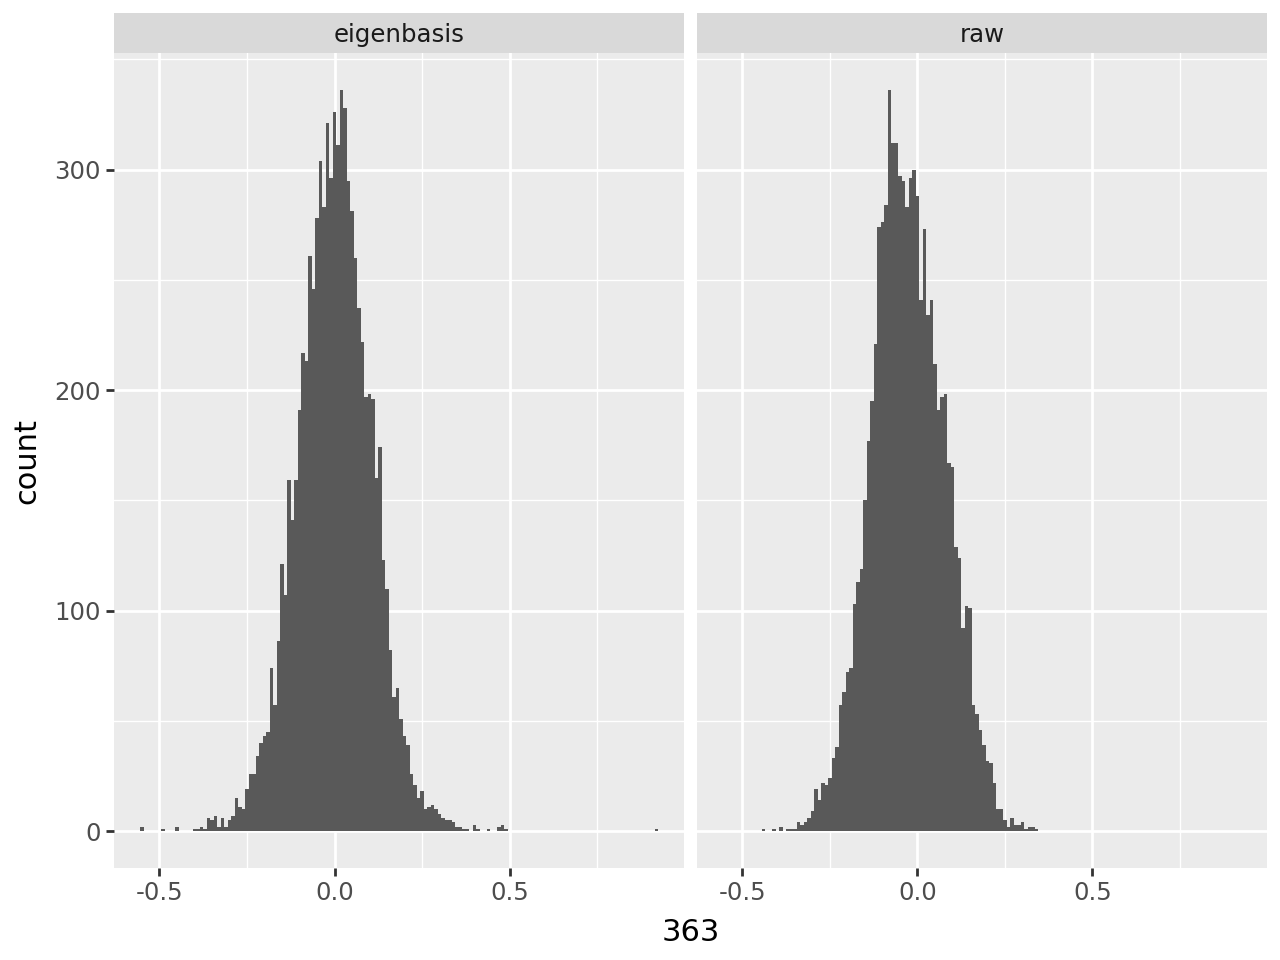

In [100]:
from random import randint

column = str(randint(0, 512))
ggplot(data, aes(x=column)) + geom_histogram(binwidth=0.01) + facet_wrap('~source')


In [14]:
from scipy.stats import entropy

def get_node_data(G, node_idx):
    in_weights = np.array([w for _, _, w in G.in_edges(node_idx)])
    out_weights = np.array([w for _, _, w in G.out_edges(node_idx)])
    in_entropy = entropy(in_weights / in_weights.sum())
    out_entropy = entropy(out_weights / out_weights.sum())
    return {
        'node_idx': node_idx,
        'ngram': G[node_idx].ngram,
        'in_weights': in_weights.tolist(),
        'out_weights': out_weights.tolist(),
        'in_degree': G.in_degree(node_idx),
        'out_degree': G.out_degree(node_idx),
        'mean_in_weight': in_weights.mean(),
        'mean_out_weight': out_weights.mean(),
        'in_weight_entropy': in_entropy,
        'out_weight_entropy': out_entropy
    }
    
    

def get_largest_sc_subgraph(graph):
    largest_scc = []
    scc_len = -1
    for cc in rx.strongly_connected_components(graph):
        if len(cc) > scc_len:
            largest_scc = cc
            scc_len = len(cc)
    return graph.subgraph(largest_scc, preserve_attrs=True)

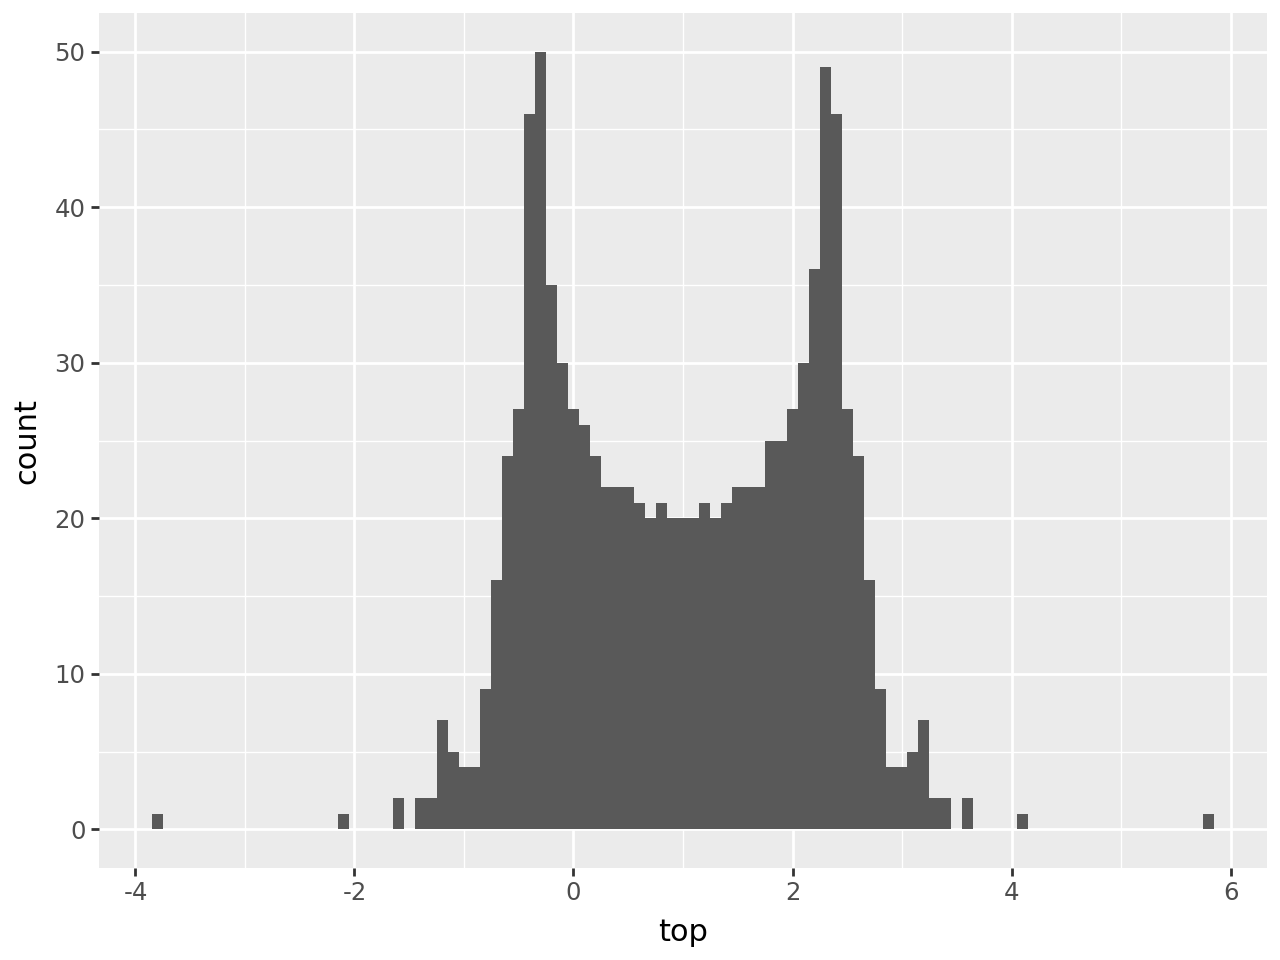

In [20]:
ggplot(eig_df, aes(x='top')) + geom_histogram(binwidth=0.1) 

In [108]:
all_node_data = [get_node_data(connected_subgraph, node) for node in connected_subgraph.node_indices()]
node_df = pl.DataFrame(all_node_data)

/home/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


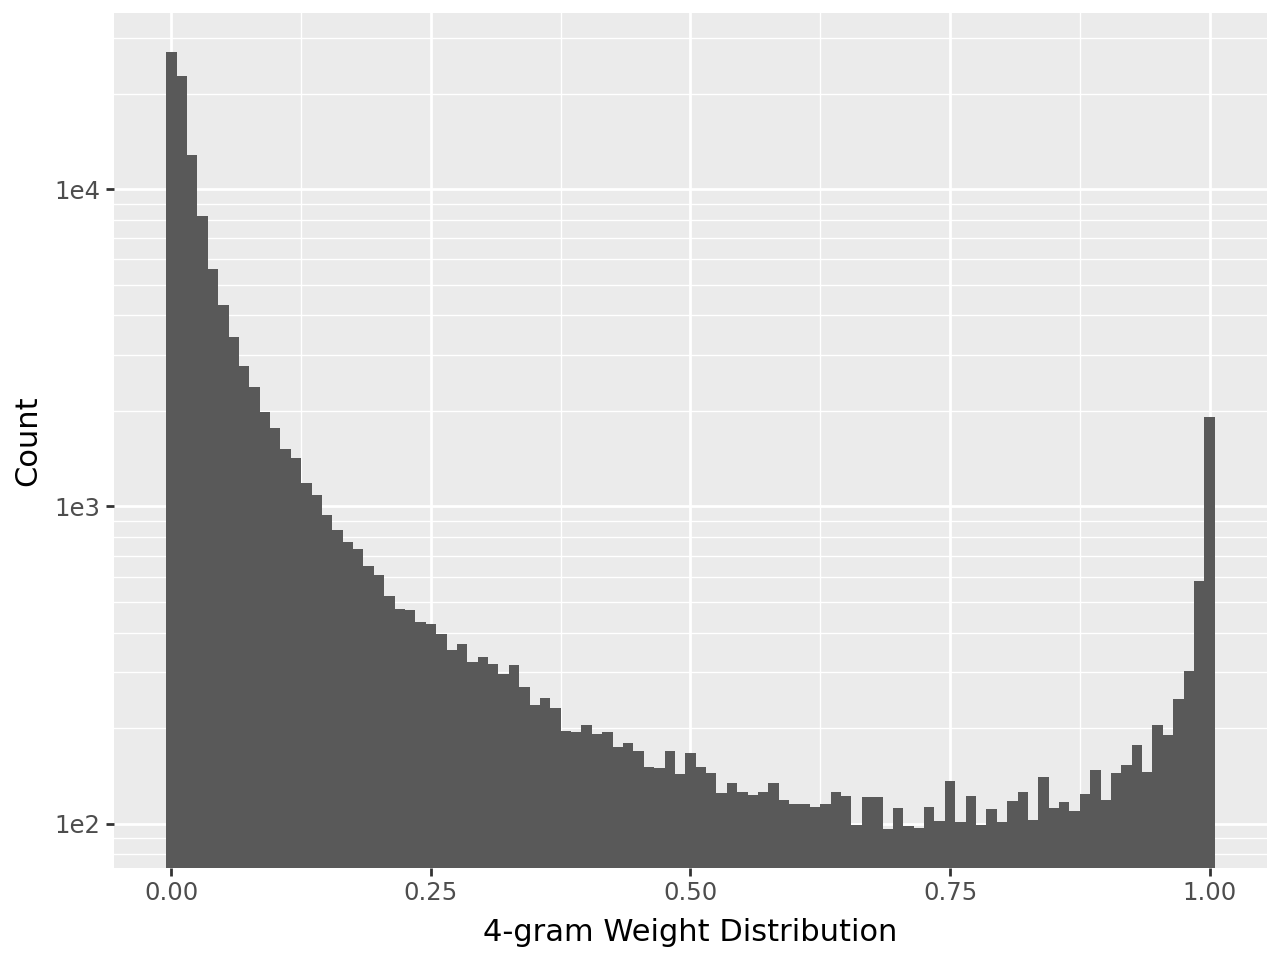

In [109]:
df = node_df.select(pl.col('in_weights')).explode('in_weights')

ggplot(df, aes(x='in_weights')) + geom_histogram(binwidth=0.01) + labs(x=f'{rw_n}-gram Weight Distribution', y='Count') + scale_y_log10()

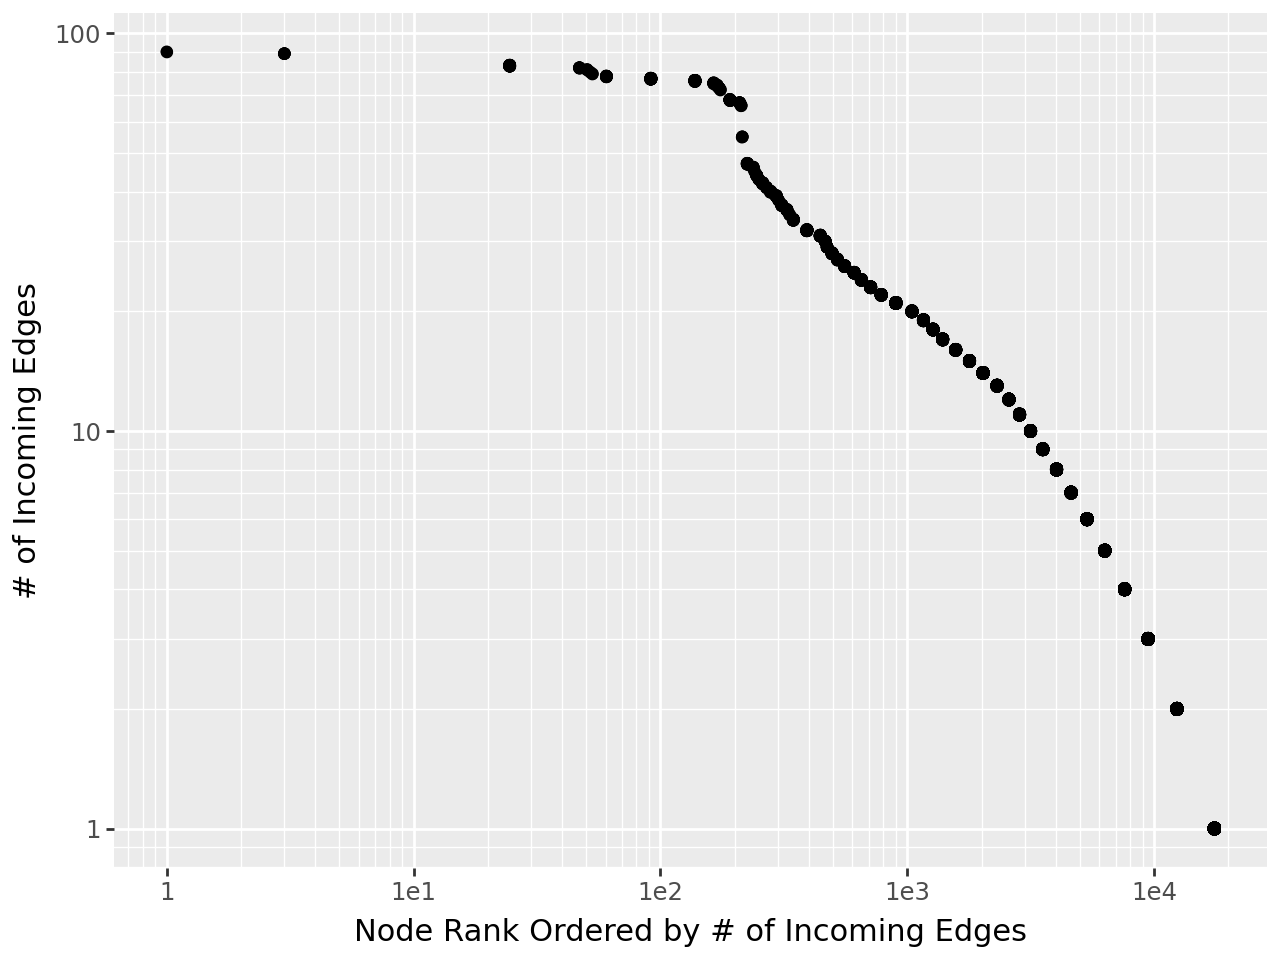

In [110]:
from plotnine import scale_x_log10, scale_y_log10, geom_jitter
df = node_df.with_columns(in_rank=pl.col('in_degree').rank(descending=True), out_rank = pl.col('out_degree').rank(descending=True))
(
    ggplot(df, aes(y='in_degree', x='in_rank')) 
    + geom_point() 
    + scale_x_log10() 
    + scale_y_log10() 
    + geom_jitter()
    + labs(x = 'Node Rank Ordered by # of Incoming Edges', y = '# of Incoming Edges')
)

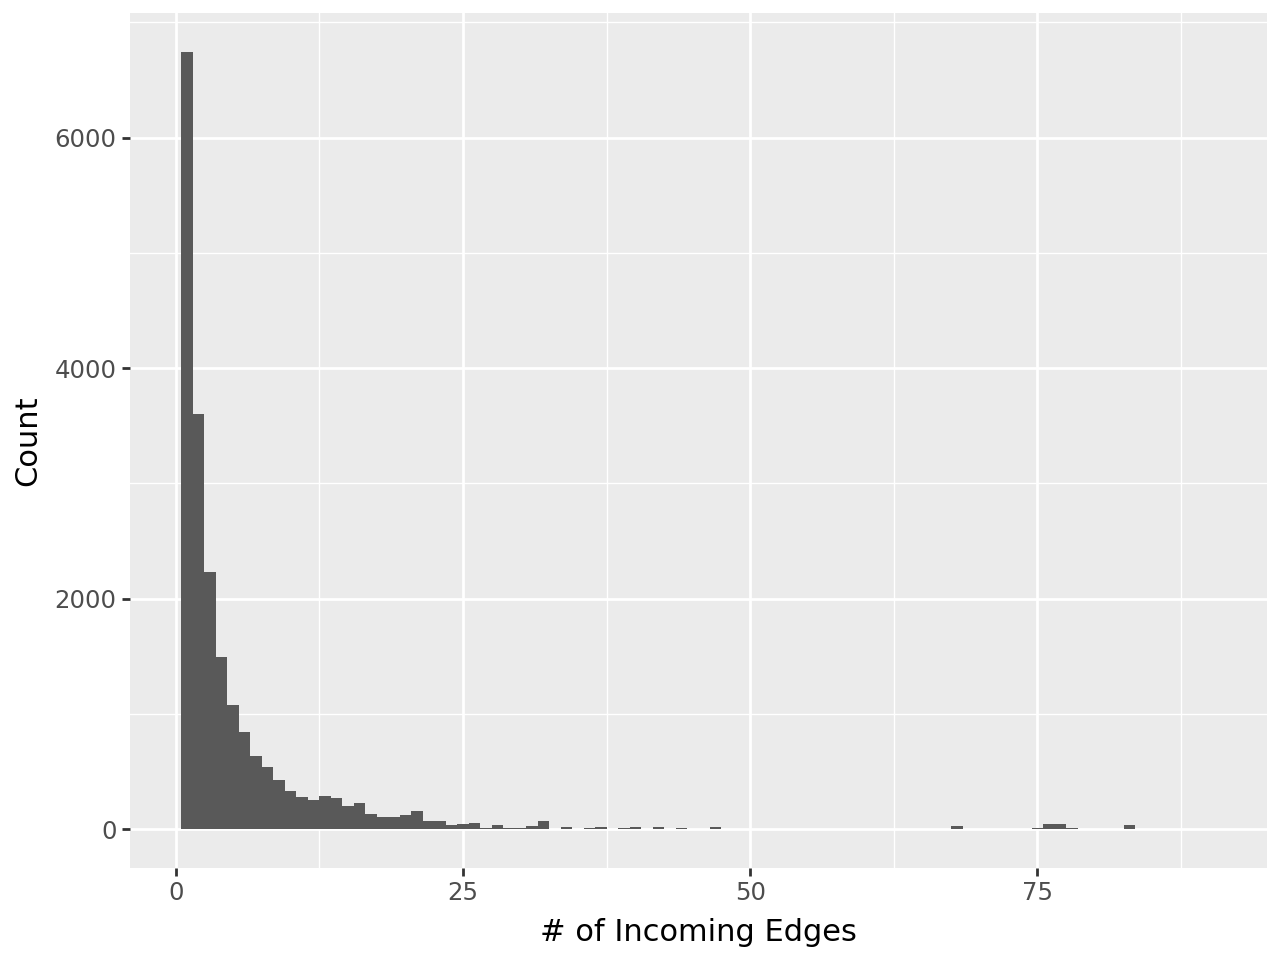

In [111]:
(
    ggplot(df, aes(x='in_degree') )
    + geom_histogram(binwidth=1) 
    + labs(y= 'Count', x = '# of Incoming Edges')
)

In [115]:
adj_mat = rx.adjacency_matrix(connected_subgraph, weight_fn= lambda x: float(x))
adj_mat /= adj_mat.sum(axis=1)[:, None]
adj_mat = torch.from_numpy(adj_mat).to(torch.float32)

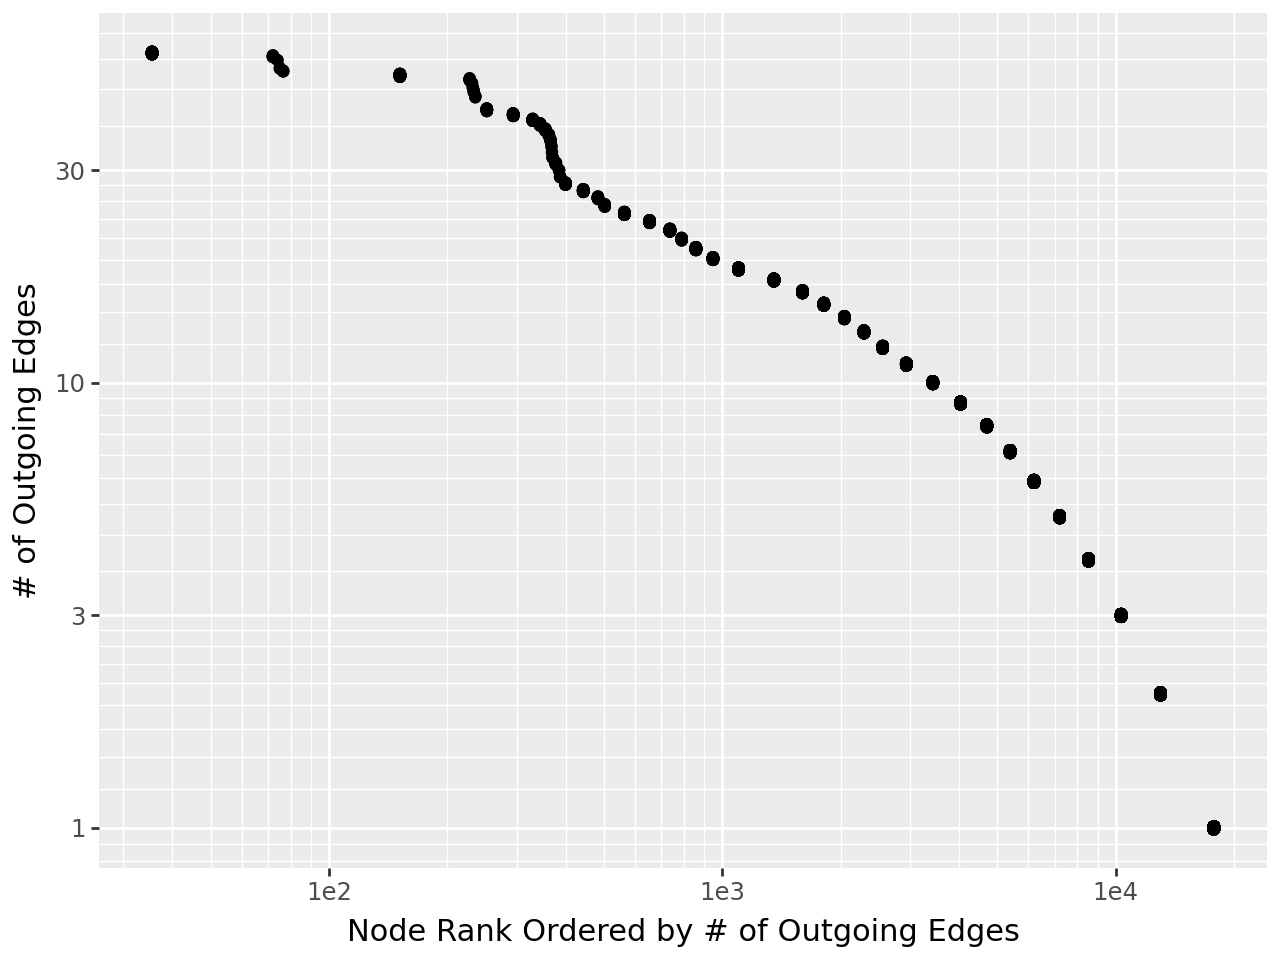

In [112]:

(
    ggplot(df, aes(y='out_degree', x='out_rank')) 
    + geom_point() 
    + scale_x_log10() 
    + scale_y_log10()
    + geom_jitter()
    + labs(x = 'Node Rank Ordered by # of Outgoing Edges', y = '# of Outgoing Edges')
)

/home/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


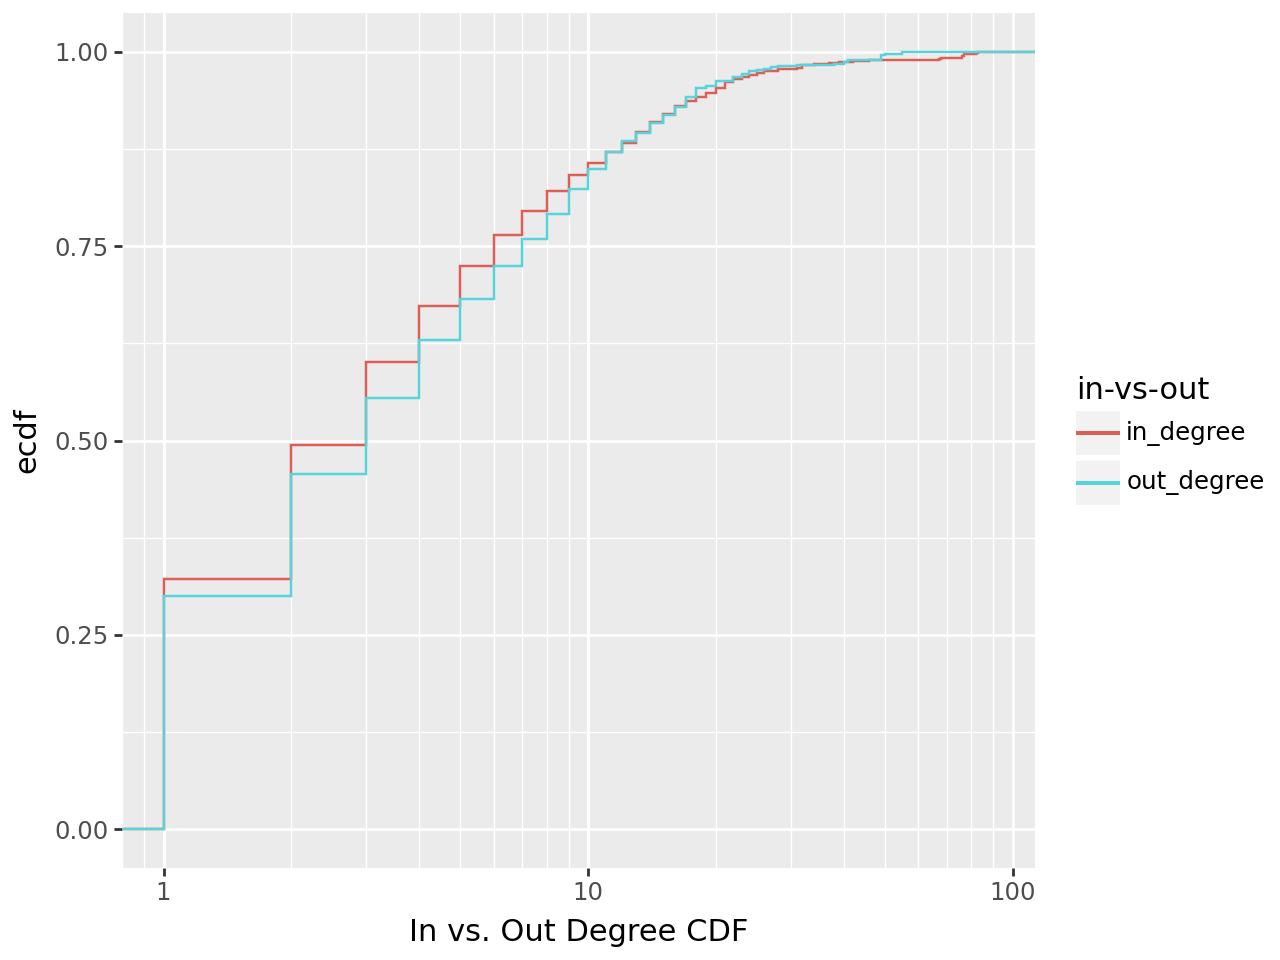

In [113]:
from plotnine import stat_ecdf

df = node_df.select(['in_degree', 'out_degree']).melt(variable_name='in-vs-out')


(
    ggplot(df, aes(x='value', color='in-vs-out'))
    + stat_ecdf(geom='step') 
    + scale_x_log10()
    + labs(x = 'In vs. Out Degree CDF')
)

In [116]:
device = torch.device('cuda:0')


In [117]:
laplacian = symmetric_directed_laplacian(adj_mat, torch.device('cpu'))
dir_laplacian = directed_laplacian(adj_mat, torch.device('cpu'))
top_eigvals, top_eigvecs = cola.eig(dir_laplacian, k=1000, which='LM')
eig_df = pl.DataFrame({'real': top_eigvals.squeeze().real.numpy(), 'imag': top_eigvals.squeeze().imag.numpy()})
ggplot(eig_df, aes(x='real', y='imag')) + geom_point() + coord_fixed()

In [118]:
laplacian.device

device(type='cpu')

In [119]:
top_eigvals, top_eigvecs = cola.eig(dir_laplacian, k=1000, which='LM')

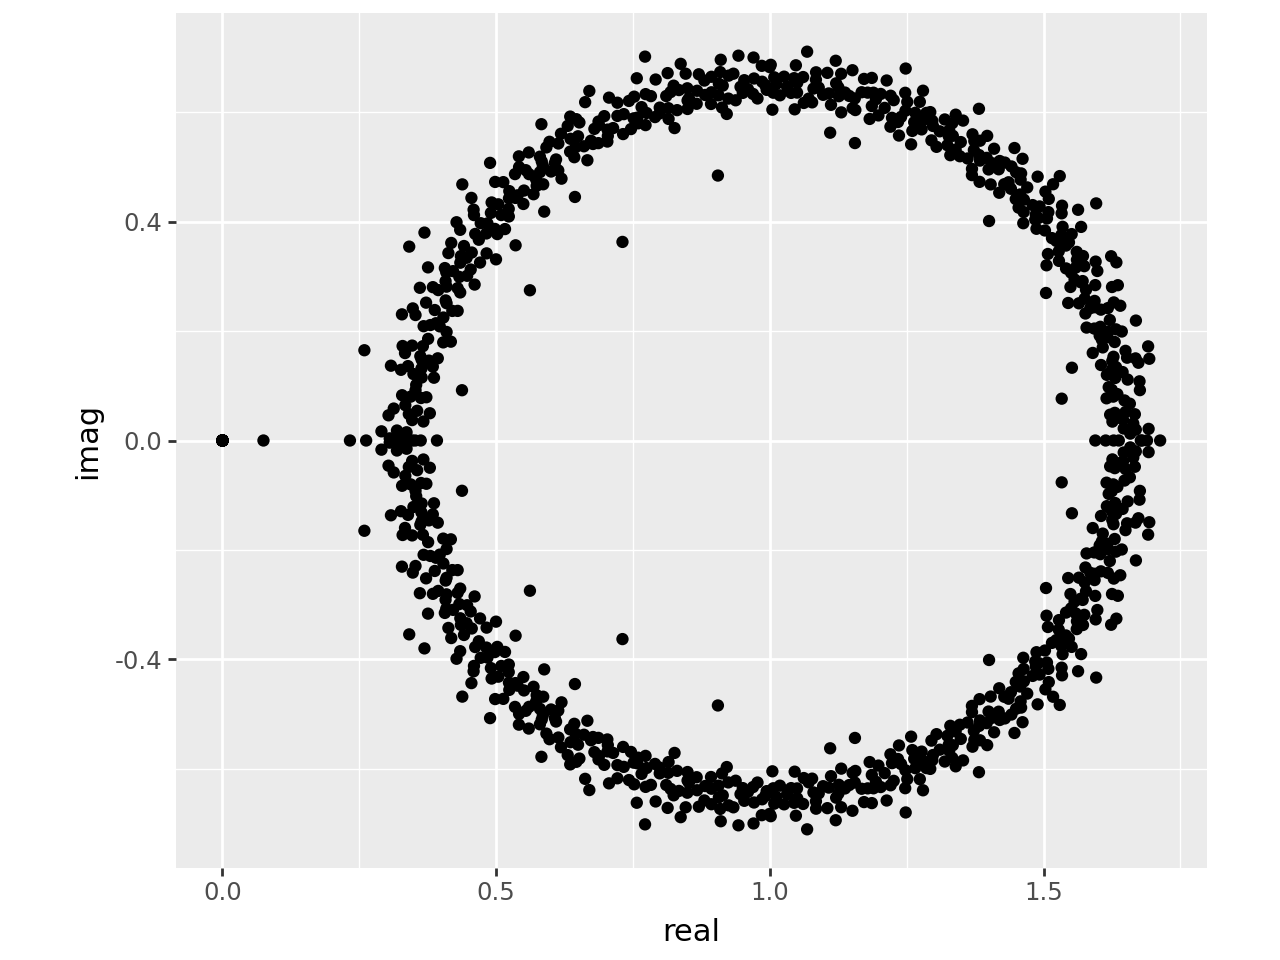

In [120]:
eig_df = pl.DataFrame({'real': top_eigvals.squeeze().real.numpy(), 'imag': top_eigvals.squeeze().imag.numpy()})
ggplot(eig_df, aes(x='real', y='imag')) + geom_point() + coord_fixed()

In [142]:
adj_mat = torch.from_numpy(
    rx.adjacency_matrix(connected_subgraph, weight_fn= lambda x: float(x))
).to(torch.float32)


sparse_adj = adj_mat.to_sparse_csr()

In [143]:
row_inds = sparse_adj.crow_indices()
col_inds = sparse_adj.col_indices()
values = sparse_adj.values()
values = values[torch.randperm(values.shape[0])]

In [149]:
new_adj = torch.sparse_csr_tensor(row_inds, col_inds, values).to_dense()
new_adj /= new_adj.sum(dim=1)[:, None]


In [150]:
laplacian = symmetric_directed_laplacian(adj_mat, torch.device('cpu'))
dir_laplacian = directed_laplacian(adj_mat, torch.device('cpu'))

In [151]:
top_eigvals, top_eigvecs = cola.eig(dir_laplacian, k=1000, which='LM')

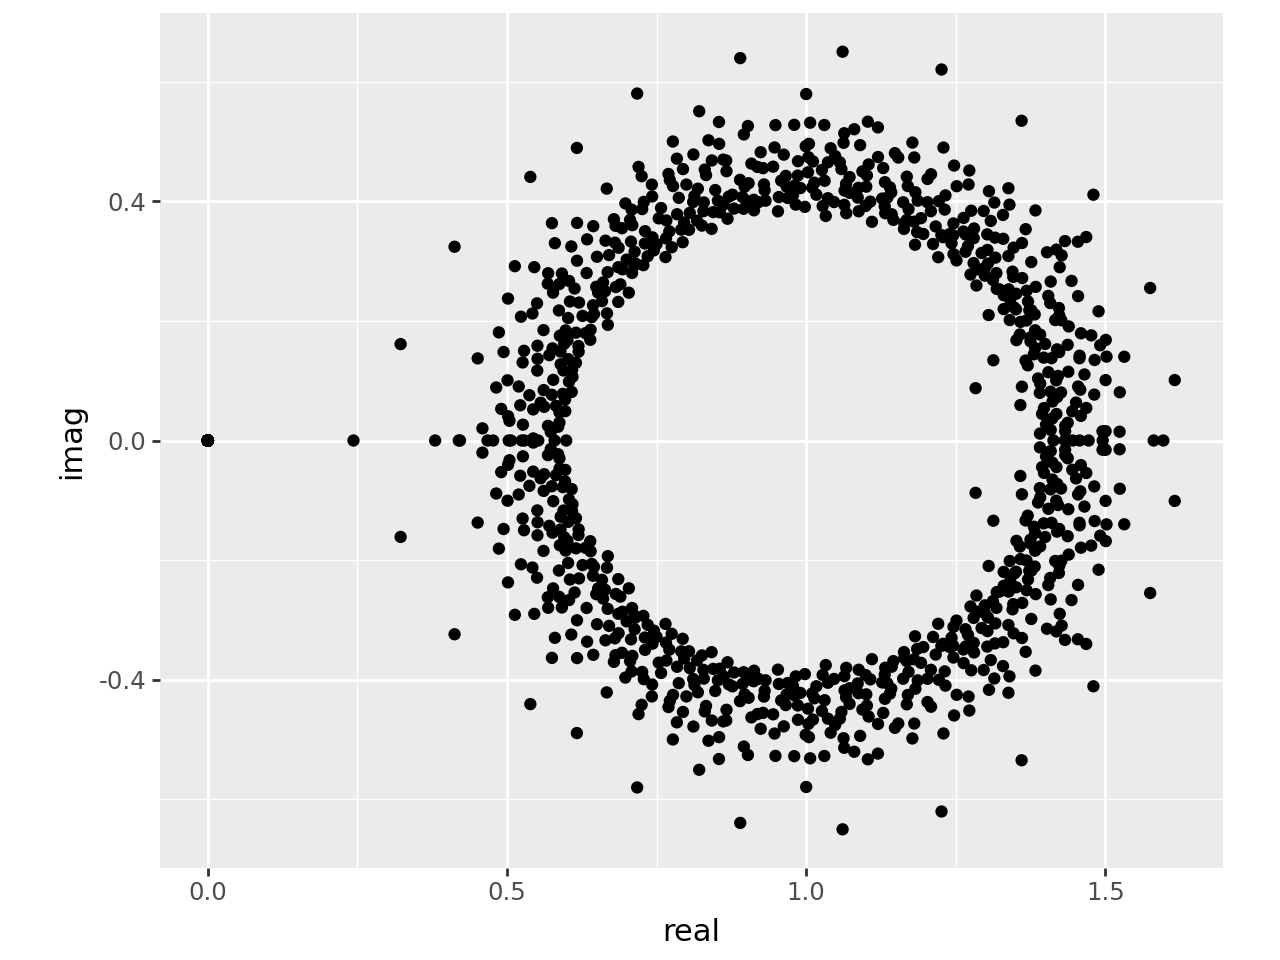

In [152]:
eig_df = pl.DataFrame({'real': top_eigvals.squeeze().real.numpy(), 'imag': top_eigvals.squeeze().imag.numpy()})
ggplot(eig_df, aes(x='real', y='imag')) + geom_point() + coord_fixed()